In [1]:
import numpy as np
import torch
from PIL import Image
import os.path
import argparse
from pathlib import Path

from torch.utils.data import DataLoader
import tqdm
from utils.factory import create_model_and_transforms, get_tokenizer
from torchvision.datasets import ImageFolder
from utils.siglip.modeling_siglip import SiglipVisionModel, SiglipTextModel
from utils.siglip.processing_siglip import SiglipProcessor
from transformers import AutoTokenizer
from utils.openai_templates import OPENAI_IMAGENET_TEMPLATES
from utils.imagenet_classes import imagenet_classes
import torch.nn.functional as F
from typing import Union, Any
from matplotlib import pyplot as plt
from compute_siglip import PRSHook
import os
os.environ["HF_HOME"] = '/mnt/data/'

/home/ubuntu/miniconda3/envs/prsclip/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/miniconda3/envs/prsclip/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# Utils:

def visualize_tensor_channels(tensor, figsize=(15, 5), cmap='viridis'):
    """
    Visualize each channel of a tensor with shape [H, W, C]
    
    Args:
        tensor: numpy array or tensor with shape [H, W, C]
        figsize: tuple for figure size
        cmap: colormap for visualization
    """
    H, W, C = tensor.shape
    
    # Calculate subplot grid dimensions
    cols = min(C, 8)  # Max 5 columns for readability
    rows = (C + cols - 1) // cols  # Ceiling division
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Handle single row case
    if rows == 1:
        axes = axes.reshape(1, -1) if C > 1 else [axes]
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten() if C > 1 else [axes]
    
    for c in range(C):
        ax = axes_flat[c]
        im = ax.imshow(tensor[:, :, c], cmap=cmap)
        ax.set_title(f'Channel {c}')
        ax.axis('off')
        
        # Add colorbar
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Hide unused subplots
    for i in range(C, len(axes_flat)):
        axes_flat[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [3]:
## Hyperparameters
device = 'cuda:0'
model_name = "google/siglip-so400m-patch14-384" 
image_name = 'images/catdog.png'

In [4]:
## All models
model = SiglipVisionModel.from_pretrained(model_name)
model.to(device)
model.eval()
processor = SiglipProcessor.from_pretrained(model_name, use_fast=True)

text_model = SiglipTextModel.from_pretrained(model_name)
text_model.to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [5]:
## Register the hook on the model's hook manager

prs_hook = PRSHook(collapse_attention=False)
model.hook.register('pooling_head.attention.out.post', prs_hook.save_attention)
model.hook.register('pooling_head.mlp_output', prs_hook.save_mlp)

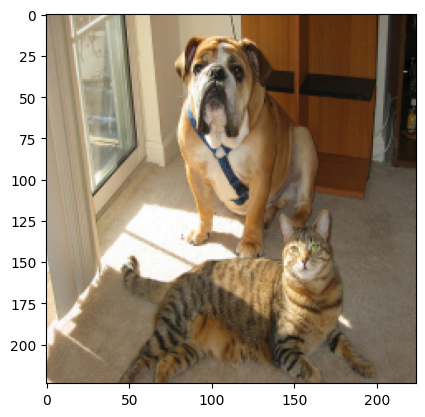

In [6]:
## Load image
image_pil = Image.open(image_name)
image = processor(images=image_pil, return_tensors="pt")
_ = plt.imshow(image_pil)

In [7]:
## Run the image:
with torch.no_grad():
    image['pixel_values'] = image['pixel_values'].to(device)
    outputs = model(**image)
    representation = outputs.pooler_output
    attn_and_mlp_results = prs_hook.finalize()

In [8]:
# Run the texts:
texts = ["A dog", "A cat"]
inputs = tokenizer(texts, truncation=False, padding="max_length", max_length=64, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
outputs = text_model(**inputs)
class_embeddings = F.normalize(outputs.pooler_output, dim=-1)

In [9]:
# Resize to image size
image_size = int(np.sqrt(attn_and_mlp_results['attention_records'].shape[2]))
heads_num = attn_and_mlp_results['attention_records'].shape[3]
reshaped_attentions = attn_and_mlp_results['attention_records'][0,0].view(image_size,image_size, heads_num, class_embeddings.shape[-1])
scores = reshaped_attentions.to(device) @ class_embeddings.t()

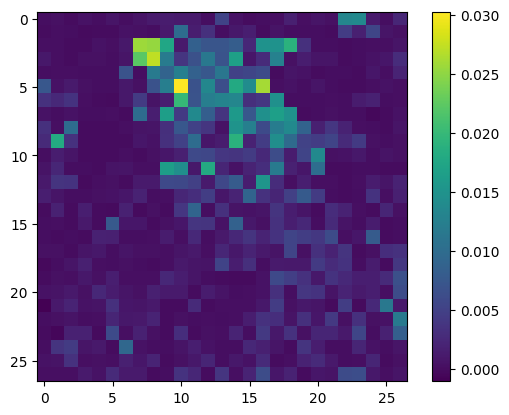

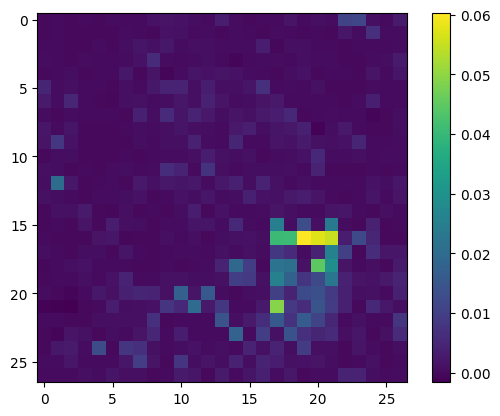

In [13]:
plt.imshow(scores[:, :, [0,1,2,3,5,7,8,9,13]].sum(axis=2)[:, :, 0].detach().cpu().numpy())
plt.colorbar()
plt.show()
plt.imshow(scores[:, :, [0,1,2,3,5,7,8,9,13]].sum(axis=2)[:, :, 1].detach().cpu().numpy())
plt.colorbar()
plt.show()

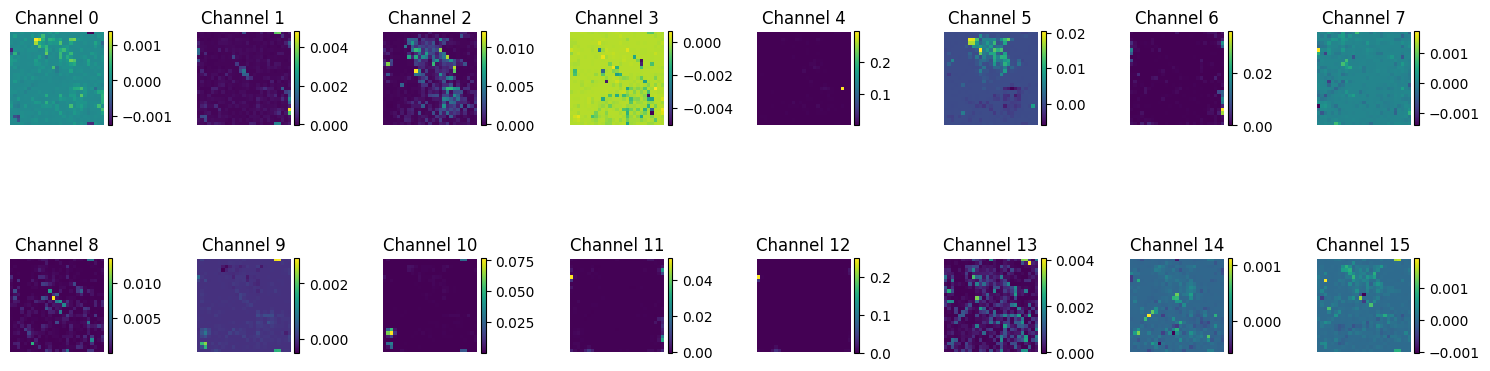

In [11]:
visualize_tensor_channels(scores.detach().cpu()[:,:,:, 0])

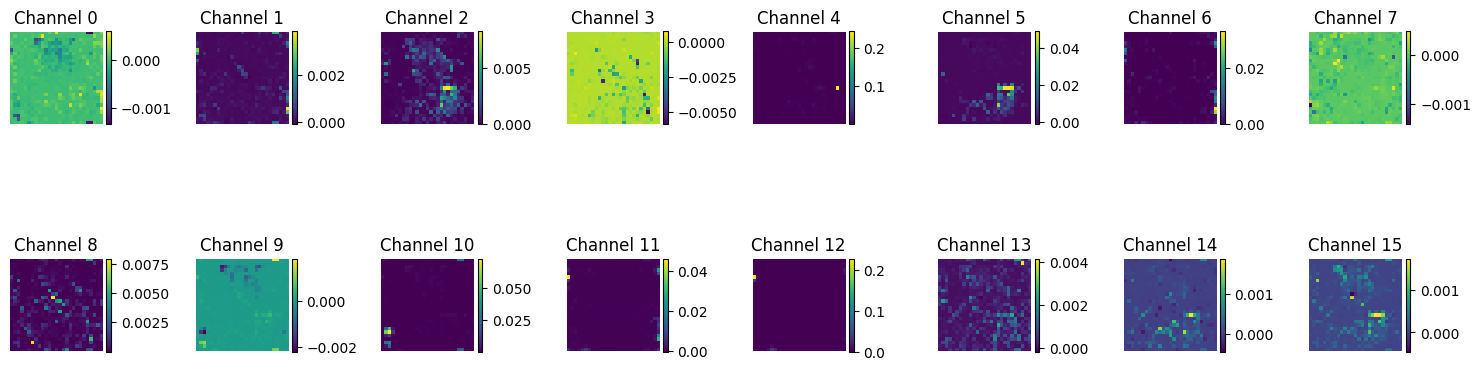

In [30]:
visualize_tensor_channels(scores.detach().cpu()[:,:,:, 1])